In [2]:
# Merge the current namespace with the namespace of setup.py
from src.setup import *
from Pyhattan import FormatData, GenerateManhattan
import scipy.stats as stats
import scipy.cluster.hierarchy as sch

# This prevents to restart the kernel whenever an external file is edited
%load_ext autoreload
%autoreload 2

from src import common
from src import host

***

# Introduction

At this point, we expect to have **clean viral and host datasets** (filtered for missingness, rare variants, HWE). Note that this clean dataset is **not the final dataset** for this study, this notebook is more about getting used to the association tests, relevant plink commands, and workflow needed for running association models. A new dataset will be created in the last notebook: we need to do QC again by keeping only asian individuals (defined by clustering, not the clinical labels) in order to avoid biases due to population stratification.

In this notebook, we simply take asian individuals into account with the clinical *RACE* label (which is, again, not what we want eventually).

###### Plan

* Principal component analysis (all individuals)
* Univariate association models
    * Y=BMI response variable, N host variant predictors (N = number of SNPs)
    * Y=random vector N(0, 1), N host variant predictors
    * Y=viral amino acid, N host variant predictors
* Multiple association models

The output of each univariate association model is summarized by plink in a table of N rows (N = number of SNPs). Eventually, running such a computation for each viral amino acid leads to M tables summerizing associations for each SNP relative to a given amino acid. 

###### Methods

* `host.plot_plink_pca` function that looks at the plink PCA data and automatically merges the PCs with a variable of the clinical data.
* `write_phenotype` function that finds the intersection of individuals in the three datasets (clinical, viral and host genotype data) and write their phenotype to a plink-readable file. Individuals can be filtered given a clinical criterion. 
* `run_assoc` function that calls `run_plink` function with relevant parameters needed for association tests.

### Phenotypes and covariates

###### Phenotypes

We now want to include some external phenotype data, i.e. the ones in the clinical data. From the [documentation of plink1.9](https://www.cog-genomics.org/plink/1.9/input#pheno) :
> --pheno causes phenotype values to be read from the 3rd column of the specified **space- or tab-delimited file**, instead of the .fam or .ped file. The first and second columns of that file must contain family and within-family IDs, respectively.
>
> In combination with --pheno, --mpheno lets you use the (n+2)th column instead of the 3rd column, while --pheno-name lets you select a column by title. (In order to use --pheno-name, there must be a header row with first two entries 'FID' and 'IID'.)

More documentation:
> To specify an alternate phenotype for analysis, i.e. other than the one in the `*.ped` file (or, if using a binary fileset, the `*.fam` file), use the --pheno option
> 
> If an individual is in the original file but not listed in the alternate phenotype file, that person's phenotype will be set to missing. If a person is in the alternate phenotype file but not in the original file, that entry will be ignored. The order of the alternate phenotype file need not be the same as for the original file. If the phenotype file contains more than one phenotype, then use the `--mpheno N` option to specify the Nth phenotype is the one to be used: 
>
> Alternatively, your alternate phenotype file can have a header row, in which case you can use variable names to specify which phenotype to use. If you have a header row, the first two variables must be labelled FID and IID. All subsequent variable names cannot have any whitespace in them.
>
> Finally, if there is more than one phenotype, then for basic association tests, it is possible to specify that all phenotypes be tested, sequentiall [...]. You might want to use the `--pfilter` command in this case, to only report results with a p-value less than a certain value, e.g. `--pfilter 1e-3`.
>
> **Warning: Currently, all phenotypes must be numerically coded, including missing values, in the alternate phenotype file. The default missing value is -9, change this with `--missing-phenotype`, but it must be a numeric value still (in contrast to the main phenotype in the PED/FAM file).**

###### Create plink-readable file

As shown above, the file should begin with a header row indicating the column names (we will want to select the phenotypes by their names). All entries must begin with FID and IID, but we can add any number of extra columns (at least 1). Values can be separated by (spaces or) *tabs*.

***
# Principal component analysis

We want to **exclude the chromosomes 6, X and Y** (no new dataset created, simply provide command to plink; that value is stored in `DEFAULT_CHROMOSOME_EXCLUSION`). We first compute the PCA for all individuals, then for asian people (based on the clinical criterion). 
We use the `--keep-fam <file>` command to keep individuals that are in all datasets. 

In [2]:
# 1. Create a file with a list individuals (provided to --keep command)
common.write_phenotypes(fam=PATH_HOST_CLEAN_DATA, output_path=PATH_INTERSECTING_INDIVIDUALS)

610 individuals written to 'data/all_intersecting_ids'
0 were filtered out based on the criteria None
The phenotype 'None' were included from clinical data.


In [3]:
# 2. Compute principal components
host.run_plink("--pca 20 --keep-fam " + PATH_INTERSECTING_INDIVIDUALS + " " + DEFAULT_CHROMOSOME_EXCLUSION,
                file=PATH_HOST_CLEAN_DATA, out=PATH_HOST_CLEAN_DATA,
                extension='eigenvec', log_name='host_pca');

Running 'plink2 --bfile data/plink/host_geno_clean --out data/plink/host_geno_clean --pca 20 --keep-fam data/all_intersecting_ids --not-chr 0 6 X Y XY MT '
Log written to 'data/plink/log/host_pca.log'


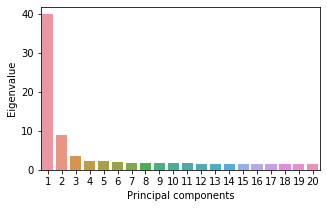

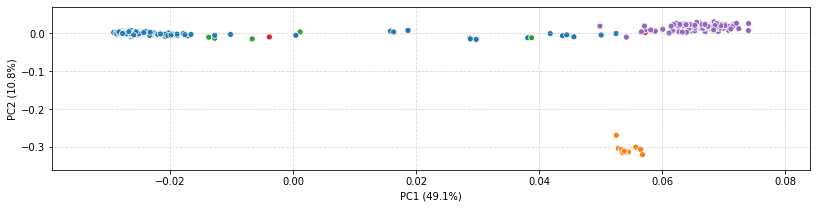

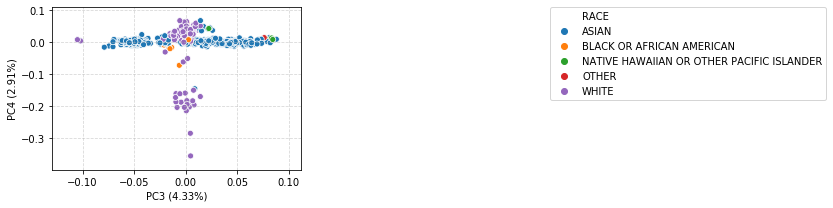

In [3]:
# 3. Plot the first components
host.plot_plink_pca(PATH_HOST_CLEAN_DATA, n_pcs=4, hue_col='RACE',
                   bbox_to_anchor=(2, 1))

***
# Association analyses


We will make use of the `write_phenotypes` function to create a file that plink can read as phenotypes. Plink sees phenotypes as response variable / outcome of a regression or association model. 

In [1]:
# QQ-plot function: expected vs observed p-values (-log10 transformation)
def plot_QQ(pvals, title, ax=None):
    # Transformation
    minlog10 = -np.log10(pvals)
    # Expected uniform distrib
    uniform_grid = np.linspace(0, 1, len(minlog10))
    # Avoid error of division by 0 -> exclude 0, thus drop an element of the other list to keep same size
    if ax==None:
        plt.scatter(x= -np.log10(uniform_grid[1:]), y=sorted(minlog10, reverse=True)[0:-1])
    else:
        ax.scatter(x= -np.log10(uniform_grid[1:]), y=sorted(minlog10, reverse=True)[0:-1])
    plt.xlabel('Theoretical value'); plt.ylabel('-log10(p)')
    plt.title(title)

## Simple univariate models

We provide to the `--pheno` and `--keep` commands the same file, written by `write_phenotypes` (by default, plink will take all individuals in the dataset and thus some would have a missing phenotype) to take the filtering criterion into account. 

### BMI

We want to apply the inverse normal distribution to that variable (see [this article](https://academic.oup.com/hmg/article/27/20/3641/5067845)). 

In [16]:
# We write the BMI of asian individuals
common.write_phenotypes(PATH_HOST_CLEAN_DATA, phenotype='BASELINE_BMI', 
                        criteria=('RACE', 'ASIAN'), output_path=PATH_WORKING_PHENOTYPES,
                        transform='invnorm')
o, e = host.run_assoc()

440 individuals written to 'data/working_pheno'
170 were filtered out based on the criteria ('RACE', 'ASIAN')
The phenotype 'BASELINE_BMI' were included from clinical data.
Running 'plink2 --bfile data/plink/host_geno_clean --out data/plink/host_geno_clean --not-chr 0 X Y XY MT --linear --pheno data/working_pheno --keep data/working_pheno '
Log written to 'data/plink/log/assoc.log'


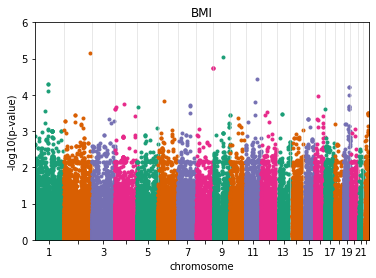

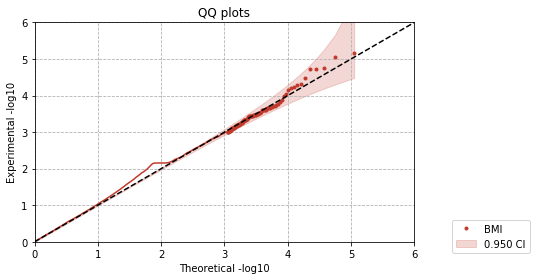

In [3]:
import warnings
warnings.filterwarnings('ignore')
host.gen_manhattan([PATH_HOST_CLEAN_DATA+'.BASELINE_BMI.glm.linear'],
                  titles=["BMI"])

###### Report

TODO: change this report

BMI is a complex trait, i.e. it is influenced by both genetic and environmental facors. In top of that, the genetic component determining BMI is driven by several genes rather than a single one. This leads to the fact that each SNP contributing to variation in BMI has a small effect size. Thus we would not necessarily require a p-value of $10^{-8}$ (common threshold in GWASs) to investigate for potentially significant SNPs, given the small sample size we are working on. However, such a simplistic monovariate model can't report the underlying complexity of such a trait. 

### Random vectors N(0, 1)

We want to investigate how random data can be predicted with the data to compare results with a reference baseline.

In [21]:
common.write_phenotypes(PATH_HOST_CLEAN_DATA, phenotype='random', 
                        criteria=('RACE', 'ASIAN'), output_path=PATH_WORKING_PHENOTYPES, verbose=False)
o, e = host.run_assoc()
#print(o)

Running 'plink2 --bfile data/plink/host_geno_clean --out data/plink/host_geno_clean --not-chr 0 X Y XY MT --linear --pheno data/working_pheno --keep data/working_pheno '
Log written to 'data/plink/log/assoc.log'


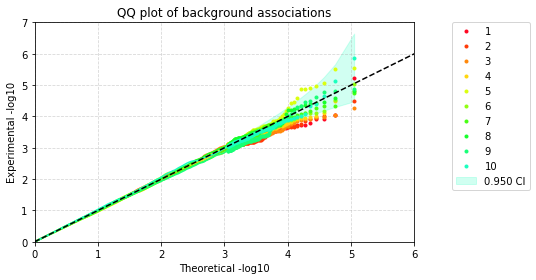

In [4]:
# 1. Load the list of p-values 
p_list = []
for i in range(10): # 10 random predictors generated by write_phenotypes
    df = pd.read_csv(PATH_HOST_CLEAN_DATA+'.'+str(i+1)+'.glm.linear', sep='\t')
    p_list.append(df[ df.TEST == 'ADD' ].P)
    
df = None
from assocplots.qqplot import *
colors = ['#FF0521', '#FF3907', '#FF8809', '#FFD60C', '#DBFF0E', '#90FF10', '#47FF12', '#15FF2B', '#17FF76', '#19FFBF']
names = [ str(i+1) for i in range(10) ]
fill_dens = [0.2] * len(p_list)
plt.grid(linestyle='--', alpha=0.5)
qqplot(p_list, 
   names, 
   color=colors, 
   fill_dens=fill_dens, 
   error_type='theoretical', 
   distribution='beta',
   title='QQ plot of background associations')
plt.gca().legend(bbox_to_anchor=(1.1,0.1*len(p_list)), loc=2, borderaxespad=0.);

### Amino acids

We'll consider `gene_PC_C_pos_0160_A` and `gene_S_pos_0035_R` amino acids, they are highly penetrant SNPs known to have an effect in HBV susceptibility of asian individuals. The binary variables (amino acid variants) makes the association model a **case-control study for that specific amino acid**: individuals that have a viral amino acid variant (binary value 1) are the cases, the others are the controls. 

In [57]:
common.write_phenotypes(PATH_HOST_CLEAN_DATA, phenotype=('S', 35, 'R'), 
                        criteria=('RACE', 'ASIAN'), output_path=PATH_WORKING_PHENOTYPES, 
                        verbose=False)
o, e = host.run_assoc(binary=True)

Running 'plink2 --bfile data/plink/host_geno_clean --out data/plink/host_geno_clean --not-chr 0 6 X Y XY MT --allow-no-sex --logistic --1 --pheno data/working_pheno --keep data/working_pheno '
Log written to 'data/plink/log/assoc.log'


In [59]:
df = pd.read_csv(PATH_HOST_CLEAN_DATA+'.S_35_R.glm.logistic', sep='\s+')
df.sort_values(by='P').head(2)

,#CHROM,POS,ID,REF,ALT,A1,TEST,OBS_CT,OR,LOG(OR)_SE,Z_STAT,P
73714,14,70245193,rs2296651,G,A,A,ADD,439,24.19570,0.371876,8.56784,1.054430e-17
91843,19,6686659,rs237554,T,C,T,ADD,438,8.81119,0.467804,4.65157,3.294180e-06


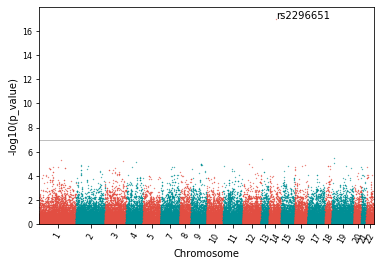

In [53]:
data = FormatData(PATH_HOST_CLEAN_DATA+'.S_35_R.glm.logistic', sep='\s+', chromosome='#CHROM', 
                  p_value='P')
GenerateManhattan(data, refSNP='ID', significance=8)

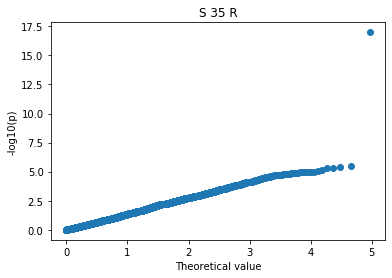

In [49]:
df = pd.read_csv(PATH_HOST_CLEAN_DATA+'.S_35_R.glm.logistic', sep='\s+', usecols=['P'])
df.dropna(inplace=True)
plot_QQ(df.P, 'S 35 R')

In [3]:
common.write_phenotypes(PATH_HOST_CLEAN_DATA, phenotype=('PC', 160, 'A'), 
                        criteria=('RACE', 'ASIAN'), output_path=PATH_WORKING_PHENOTYPES, 
                        verbose=False)
o, e = host.run_assoc(binary=True)

Running 'plink2 --bfile data/plink/host_geno_clean --out data/plink/host_geno_clean --not-chr 0 X Y XY MT --1 --logistic hide-covar --pheno data/working_pheno --keep data/working_pheno '
Log written to 'data/plink/log/assoc.log'


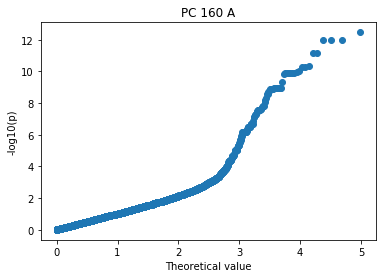

In [9]:
df = pd.read_csv(PATH_HOST_CLEAN_DATA+'.PC_160_A.glm.logistic', sep='\s+', usecols=['P'])
df.dropna(inplace=True)
plot_QQ(df.P, 'PC 160 A')

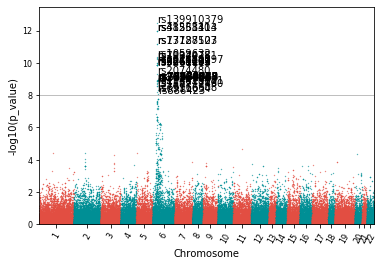

In [11]:
data = FormatData(PATH_HOST_CLEAN_DATA+'.PC_160_A.glm.logistic', sep='\s+', chromosome='#CHROM', 
                  p_value='P')
GenerateManhattan(data, refSNP='ID', significance=8)

## Report

For both `gene_PC_C_pos_0160_A` and `gene_S_pos_0035_R` amino acids, we observe a highly significant association with the `rs2296651` SNP. See the article

[The rs2296651 (S267F) variant on NTCP (SLC10A1) is inversely associated with chronic hepatitis B and progression to cirrhosis and hepatocellular carcinoma in patients with chronic hepatitis B.](https://www.ncbi.nlm.nih.gov/pubmed/26642861)
> Sodium taurocholate cotransporting polypeptide (NTCP) is a functional receptor for hepatitis B virus (HBV) infection. NTCP rs2296651 is believed to be an Asian‐specific variant responsible for HBV susceptibility.

# Clustering

Refer to the Statistics notebook and to the reference book specified below. Clustering is a type of problem in unsupervised learning together with dimensional reduction (PCA) and other ones. Clustering aims to partition unlabeled data items into disjoint subsets of clusters that have:

* high interclass similarity
* low interclass similarity

###### Types of input

* similarity-based clustering: input is nxn matrix
* feature-based clustering: input is nxD design matrix

###### Clustering techniques

* soft partition: probabilistic model
* hard partition: assign well defined membership 
    * paritional (ex K-means, spectral clustering)
    * hierarchichal

Here we need **hierarchical** hard partition clustering. 

###### References

This *Clustering* section of the notebook is based on the following book (except when a link is present): Santi Seguí, and Laura Igual. *Introduction to Data Science : A Python Approach to Concepts, Techniques and Applications*, (*CH7 Unsupervised learning*). Web.

## Hierarchichal clustering

> [...] algorithms that construct nested clusters by successive merging or splitting of data. The hierarchy of clusters is represented as a tree. The tree is usually called a **_dendrogram_**. The root of the dendrogram is the single cluster that contains all the samples; the leaves are the clusters containing only one sample each. This is a nice tool, since it can be straightforwardly interpreted: it “explains” how clusters are formed and
visualizes clusters at different scales. The tree that results from the technique shows the *similarity between the samples*. Partitioning is computed by **selecting a cut on the tree** at a certain level.

###### Types of hierarchichal clustering:

* top-down: start with all data in one cluster, iteratively splits clusters
* bottom-up: start with each datapoint in a different cluster, iteratively merges clusters

###### Measure similarity - bottom up

Linkage criterion defines some metrics used in agglomerative clustering:

* Maximum or complete linkae minimizes distance between observations of pairs of clusters. Tend to give clusters a spherical shape. 
* Average linkage averages similarity between members thus minimizes the mean distance between all possible pair of clusters.
* **Ward** linkage minimizes the sum of squared differences within all clusters. It's a variance minimizing approach.



###### [Example](https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/)

In [16]:
import scipy.cluster.hierarchy as hierarchy
from scipy.cluster.hierarchy import dendrogram

In [20]:
X = np.array([[5,3], [10,15], [15,12], [24,10], [30,30], [85,70], [71,80],
            [60,78], [70,55], [80,91],])
Z = hierarchy.linkage(X, 'single')
labels = range(11)

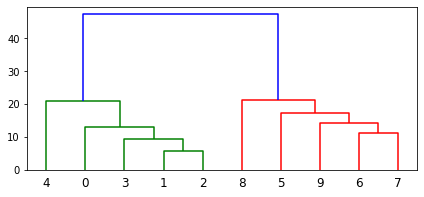

In [23]:
plt.figure(figsize=(7,3))
dn1 = dendrogram(Z)

We explicitely see the **bottom-up** aspect of this kind of clustering.

## Load the pcs

In [14]:
df_pca = pd.read_csv(PATH_HOST_CLEAN_DATA+'.eigenvec', sep="\s+")

## Clustering with scipy

https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Clustering-Dimensionality-Reduction/Hierarchical_Clustering.ipynb

In [9]:
import scipy.cluster.hierarchy as sch

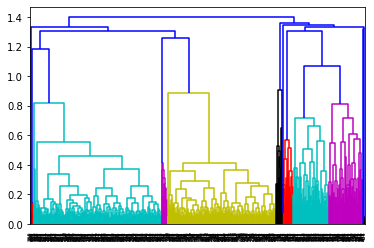

In [15]:
ward = sch.linkage(df_pca.drop(['#FID', 'IID'], axis=1), method = 'ward')
dendrogram = sch.dendrogram(ward)

In [64]:
common.write_covariates(fam=PATH_HOST_CLEAN_DATA,
                        criteria=('RACE', 'ASIAN'), 
                        output_path="data/test/covar", 
                        host_pcs=PATH_HOST_CLEAN_DATA+'.eigenvec', 
                        virus_pcs=None);

440 individuals written to 'None'
170 were filtered out based on the criteria ('RACE', 'ASIAN')
The covariates '['AGE', 'SEX']' was included.
